In [1]:
##libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt

,EOYBYear,collectDate,marshName,siteName,locationID,monitoringPurpose,Transect,Replicate,speciesName,liveMass,deadMass,totalMass,latitude,longitude
12,1999,NaT,Bellvue,Bellvue,4,EOYB,D,b,Spartina alterniflora,454.40,1.6,456.00,37.625273,-75.671577
13,1999,NaT,Bellvue,Bellvue,2,EOYB,D,b,Spartina alterniflora,884.80,158.4,1043.20,37.625273,-75.671577
14,1999,NaT,Bellvue,Bellvue,2,EOYB,D,a,Spartina alterniflora,790.40,236.8,1027.20,37.625273,-75.671577
15,1999,NaT,Bellvue,Bellvue,1,EOYB,D,b,Spartina alterniflora,2136.00,185.6,2321.60,37.625273,-75.671577
16,1999,NaT,Bellvue,Bellvue,1,EOYB,D,a,Spartina alterniflora,2324.80,104.0,2428.80,37.625273,-75.671577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8203,2017,2017-08-14,Oyster,Oyster,3,EOYB,B,a,Spartina alterniflora,NaN,NaN,156.00,37.287549,-75.929133
8204,2017,2017-08-14,Oyster,Oyster,3,EOYB,B,b,Spartina alterniflora,NaN,NaN,36.16,37.287549,-75.929133
8232,2017,2017-08-04,Gator Tract,Gator,3,EOYB,C,a,Spartina alterniflora,42.72,0.0,42.72,37.167409,-75.940586
8234,2018,2017-08-14,Box Tree,Box_Tree,1,EOYB,C,a,Spartina alterniflora,255.04,0.0,255.04,37.395746,-75.876094


mean biomass is: 451.6215966804981
median biomass is: 372.24


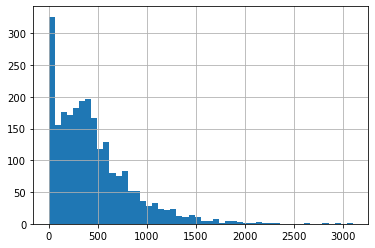

In [9]:
##read data - biomass, Virginia LTER
##Mac:
# df = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_ChristianBlum.csv', skiprows=21)
# df_wq = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_WQ.csv', skiprows=21)

##PC:
df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Virginia_ChristianBlum.csv', skiprows=21)
# df_wq = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Virginia_WQ.csv', skiprows=21, \
#                     encoding='cp1252') ##Have no idea what's with this encoding argument but it works

##Begin:
df = df[df['speciesName'] == 'Spartina alterniflora'] ##only low marsh and creekbank?

df = df[
    [
        'EOYBYear', 'collectDate', 'marshName', 'siteName', 'locationID', 'monitoringPurpose','Transect', 'Replicate',
        'speciesName', 'liveMass', 'deadMass', 'totalMass', 'latitude', 'longitude'
    ]
]

df['collectDate'] = pd.to_datetime(df['collectDate'])

df['liveMass'] = 16 * df['liveMass'] ##look at histograms
df['deadMass'] = 16 * df['deadMass']
df['totalMass'] = 16 * df['totalMass']

locations = [1, 2] ## 1 = creekbank; 2 = low marsh
#df = df[df['locationID'].isin(locations)] ##MOSTLY Spartina alterniflora-only plots; in other zones plots were mixed

# df_wq['measureDate'] = pd.to_datetime(df_wq['measureDate'])

max(df['liveMass'])

#df['liveMass'].hist(by=df['siteName'])
df['liveMass'].hist(bins = 50)

df.loc[df.marshName == 'Hog Island North', 'siteName'] = "Hog_N"
df.loc[df.marshName == 'Hog Island South', 'siteName'] = "Hog_S" ##Important for importing lat/longs

##IMPORTANT NOTE: 2017 data does not distinguish live from dead biomass due to a freezer failure

display(df)

print('mean biomass is: ' +str(df['liveMass'].mean()))
print('median biomass is: ' +str(df['liveMass'].median()))

In [3]:
##summary statistics
df_means = df.groupby(['EOYBYear', 'siteName'], as_index = False).aggregate({'liveMass':[np.mean, np.size, np.std], \
    'longitude':[np.mean, np.std], 'latitude':[np.mean], 'EOYBYear':'first', 'speciesName':'first'})

df_means.columns = ['siteName','liveMass','n','std', 'Longitude', 'lon_std', 'Latitude', 'Year', 'Species']

df_means = df_means[df_means['siteName'] != 'Broad_Creek'] ##Remove from dataset

df_sem = df.groupby('EOYBYear').sem()

display(df_means)
#df_sem

##export data
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'va_meanmass.csv')

# df_means.to_csv(out_csv, index = False)

,siteName,liveMass,n,std,Longitude,lon_std,Latitude,Year,Species
0,Bellvue,642.700000,16,738.508125,-75.671577,0.0,37.625273,1999,Spartina alterniflora
1,Box_Tree,87.280000,8,122.078337,-75.876094,0.0,37.395746,1999,Spartina alterniflora
3,Channel_Point,774.821053,19,658.653461,-75.652248,0.0,37.709249,1999,Spartina alterniflora
4,Cushmans,210.492632,19,208.344292,-75.942331,0.0,37.175055,1999,Spartina alterniflora
5,Gator,100.404211,19,146.896115,-75.940586,0.0,37.167409,1999,Spartina alterniflora
...,...,...,...,...,...,...,...,...,...
160,Hog_N,237.173333,12,135.897662,-75.672871,0.0,37.451132,2017,Spartina alterniflora
161,Hog_S,154.968889,18,165.561196,-75.698262,0.0,37.407676,2017,Spartina alterniflora
162,Oyster,274.773333,12,187.060452,-75.929133,0.0,37.287549,2017,Spartina alterniflora
163,Box_Tree,255.040000,1,NaN,-75.876094,NaN,37.395746,2018,Spartina alterniflora


In [4]:
##grouped by site and by year
mn_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).aggregate([np.mean, np.size, np.std]).reset_index()
se_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).sem()

newdf = df.groupby(['siteName', 'EOYBYear'], as_index = False).mean()

##rearrange lat and long for GEE
mn_siteyears = mn_siteyears[['siteName', 'EOYBYear', 'locationID', 'liveMass', 'longitude', \
                             'latitude', 'deadMass', 'totalMass']]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
    #print(mn_siteyears)

#print(se_siteyears)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'outx2.csv')
#se_siteyears.to_csv(out_csv, index=False) ##set out directory

newdf['year'] = newdf['EOYBYear']
print(df)
print(df['siteName'].unique())

      EOYBYear collectDate         marshName  siteName  locationID  \
12        1999         NaT           Bellvue   Bellvue           4   
13        1999         NaT           Bellvue   Bellvue           2   
14        1999         NaT           Bellvue   Bellvue           2   
15        1999         NaT           Bellvue   Bellvue           1   
16        1999         NaT           Bellvue   Bellvue           1   
...        ...         ...               ...       ...         ...   
8203      2017  2017-08-14            Oyster    Oyster           3   
8204      2017  2017-08-14            Oyster    Oyster           3   
8232      2017  2017-08-04       Gator Tract     Gator           3   
8234      2018  2017-08-14          Box Tree  Box_Tree           1   
8236      2018  2017-08-14  Hog Island North     Hog_N           3   

     monitoringPurpose Transect Replicate            speciesName  liveMass  \
12                EOYB        D         b  Spartina alterniflora    454.40   
13 

In [5]:
##Adding in location data from Linda Blum et al
marsh_elev = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/marsh_elev.csv')

site_dict = {
    'BT':'Box_Tree',
    'CM':'Cushmans',
    'GT':'Gator',
    'IT':'Indiantown',
    'MC':'Mill_Creek',
    'NB':'N_Brownsville',
    'NH':'Hog_N',
    'OS':'Oyster',
    'SH':'Hog_S',
    'SM':'Steelmans',
    'WF':'Woodland_Farm'
}

for k, v in site_dict.items():
    marsh_elev['Site'] = marsh_elev['Site'].str.replace(k, v)

marsh_elev.rename(columns={'Site':'siteName', 'Zone':'locationID'}, inplace = True)
    
##THIS STEP BELOW FIXES AN ISSUE WITH REPLICATE N_BROWNSVILLE VALUES
##There were replicate Zone/Transect (locationID/Transect) combinations only at this site; picked first lat/long
marsh_elev = marsh_elev.groupby(['locationID', 'Transect', 'siteName'], as_index = False).aggregate('first') 

print(marsh_elev)
df.rename(columns={'EOYBYear':'Year'}, inplace=True)

dfz = pd.merge(df, marsh_elev, on = ['siteName', 'Transect', 'locationID'], how = 'left')
dfz ##More specific Lat/longs (the CAPITALIZED ones) added to VA Biomass dataset

##Missing some sites! Also new lat/longs vs old ones and data extraction will be messy. Follow GA Biomass example

     locationID Transect       siteName  Code   Latitude  Longitude      Ell  \
0             1        A       Box_Tree  BTAC  37.395461 -75.876249  -36.368   
1             1        A       Cushmans  CMAC  37.174764 -75.942417  -36.613   
2             1        A             GC  GCAC  37.485296 -75.814784  -36.347   
3             1        A          Gator  GTAC  37.167147 -75.940768  -36.587   
4             1        A          Hog_N  NHAC  37.451262 -75.672535  -36.904   
..          ...      ...            ...   ...        ...        ...      ...   
196           5        D     Indiantown  ITD4  37.346772 -75.901060  -37.507   
197           5        D     Mill_Creek  MCD4  37.415987 -75.861610  -35.769   
198           5        D         Oyster  OSD4  37.287885 -75.928427  -34.381   
199           5        D      Steelmans  SMD4  37.183104 -75.944945  -32.724   
200           5        D  Woodland_Farm  WFD4  37.480213 -75.817595  -35.573   

        MSL  
0     0.681  
1     0.438

,Year,collectDate,marshName,siteName,locationID,monitoringPurpose,Transect,Replicate,speciesName,liveMass,deadMass,totalMass,latitude,longitude,Code,Latitude,Longitude,Ell,MSL
0,1999,NaT,Bellvue,Bellvue,4,EOYB,D,b,Spartina alterniflora,454.40,1.6,456.00,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
1,1999,NaT,Bellvue,Bellvue,2,EOYB,D,b,Spartina alterniflora,884.80,158.4,1043.20,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
2,1999,NaT,Bellvue,Bellvue,2,EOYB,D,a,Spartina alterniflora,790.40,236.8,1027.20,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
3,1999,NaT,Bellvue,Bellvue,1,EOYB,D,b,Spartina alterniflora,2136.00,185.6,2321.60,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
4,1999,NaT,Bellvue,Bellvue,1,EOYB,D,a,Spartina alterniflora,2324.80,104.0,2428.80,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,2017,2017-08-14,Oyster,Oyster,3,EOYB,B,a,Spartina alterniflora,NaN,NaN,156.00,37.287549,-75.929133,OSB2,37.287875,-75.929008,-36.415,0.634
2447,2017,2017-08-14,Oyster,Oyster,3,EOYB,B,b,Spartina alterniflora,NaN,NaN,36.16,37.287549,-75.929133,OSB2,37.287875,-75.929008,-36.415,0.634
2448,2017,2017-08-04,Gator Tract,Gator,3,EOYB,C,a,Spartina alterniflora,42.72,0.0,42.72,37.167409,-75.940586,GTC2,37.167768,-75.944280,-36.020,1.031
2449,2018,2017-08-14,Box Tree,Box_Tree,1,EOYB,C,a,Spartina alterniflora,255.04,0.0,255.04,37.395746,-75.876094,BTCC,37.396051,-75.876056,-36.210,0.839


In [6]:
##Exporting CSV file
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'va_allpoints.csv')
# dfz.to_csv(out_csv, index = False)

In [8]:
##Coord_years for Virginia
coords_1999 = dfz[dfz['Year'] == 1999]
coords_2000 = dfz[dfz['Year'] == 2000]
print(len(coords_2000[['Longitude']]))
coords_2001 = dfz[dfz['Year'] == 2001]
coords_2002 = dfz[dfz['Year'] == 2002]
coords_2003 = dfz[dfz['Year'] == 2003]
coords_2004 = dfz[dfz['Year'] == 2004]
coords_2005 = dfz[dfz['Year'] == 2005]
coords_2006 = dfz[dfz['Year'] == 2006] ##No data
coords_2007 = dfz[dfz['Year'] == 2007]
coords_2008 = dfz[dfz['Year'] == 2008]
coords_2009 = dfz[dfz['Year'] == 2009]
coords_2010 = dfz[dfz['Year'] == 2010]
coords_2011 = dfz[dfz['Year'] == 2011]
coords_2012 = dfz[dfz['Year'] == 2012]
coords_2013 = dfz[dfz['Year'] == 2013]
coords_2014 = dfz[dfz['Year'] == 2014]
coords_2015 = dfz[dfz['Year'] == 2015]
coords_2016 = dfz[dfz['Year'] == 2016]
coords_2017 = dfz[dfz['Year'] == 2017] ##Freezer failure year
coords_2018 = dfz[dfz['Year'] == 2018] ##Last year, only 2 observations
print(len(coords_2018[['Longitude']]))
# print(coords_2017)

#Export CSV file
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'coords_1999.csv')
# coords_1999.to_csv(out_csv, index = False)

240
2


In [9]:
##Extracting values in GEE!

,Year,collectDate,marshName,siteName,locationID,monitoringPurpose,Transect,Replicate,speciesName,liveMass,deadMass,totalMass,latitude,longitude,Code,Latitude,Longitude,Ell,MSL
0,1999,NaT,Bellvue,Bellvue,4,EOYB,D,b,Spartina alterniflora,454.4,1.60,456.00,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
1,1999,NaT,Bellvue,Bellvue,2,EOYB,D,b,Spartina alterniflora,884.8,158.40,1043.20,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
2,1999,NaT,Bellvue,Bellvue,2,EOYB,D,a,Spartina alterniflora,790.4,236.80,1027.20,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
3,1999,NaT,Bellvue,Bellvue,1,EOYB,D,b,Spartina alterniflora,2136.0,185.60,2321.60,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
4,1999,NaT,Bellvue,Bellvue,1,EOYB,D,a,Spartina alterniflora,2324.8,104.00,2428.80,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,1999,NaT,Woodland Farm,Woodland_Farm,3,EOYB,B,a,Spartina alterniflora,0.0,977.60,977.60,37.481998,-75.819360,WFB2,37.481601,-75.818583,-36.012,1.038
277,1999,NaT,Woodland Farm,Woodland_Farm,1,EOYB,C,a,Spartina alterniflora,129.6,56.00,185.60,37.481998,-75.819360,WFCC,37.481756,-75.819638,-36.222,0.828
278,1999,NaT,Woodland Farm,Woodland_Farm,2,EOYB,C,a,Spartina alterniflora,388.8,185.60,574.40,37.481998,-75.819360,WFC1,37.481484,-75.819201,-36.236,0.814
279,1999,NaT,Woodland Farm,Woodland_Farm,2,EOYB,C,b,Spartina alterniflora,315.2,328.00,643.20,37.481998,-75.819360,WFC1,37.481484,-75.819201,-36.236,0.814


In [6]:
##some figures
#df.boxplot(column='liveMass', by='EOYBYear')
#mn_siteyears.boxplot(column='liveMass', by='siteName') ##using averages as individual points


# #my_path = os.path.abspath('/Users/asariversjulien/Documents/Georgia/Project')
# #my_file = 'p1.png'
# #g.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')

print("hi")

hi
